In [1]:
import numpy as np
import pymc as pm
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# CSF dynamics model
def dyn_model(Rcsf, E, P_0):
    I_b = (Data["P_b"] - P_0) / Rcsf # CSF formation rate

    infstart = Data["infusion_start_frame"]
    infend = Data["infusion_end_frame"]
    I_inf = Data["I_inf"]

    Rn = Data["Rn"] # Needle resistance (one-needle)
    dP = Data["P_b"] - P_0
    It = I_b + I_inf

    t = (np.arange(infstart, infend + 1) - infstart) / 6.0
    Pm = It * dP / (I_b + (I_inf * tt.exp(-E * It * t))) + P_0 + (I_inf * Rn)

    return Pm


In [7]:
# Assuming data, params_means, params_stddevs, lower_bounds, upper_bounds, Data and dyn_model are pre-defined
Data =	{
  "P_b": 10.5,
  "infusion_start_frame": 1,
  "infusion_end_frame": 100,
  "I_inf": 1.5,
  "Rn": 2.0,
}
P_b = 13
params_means = [10.45, 0.33, 7.5]
params_stddevs = [2.03, 0.08, 1.5]
lower_bounds = [0.01, 0.01, -10.0]
upper_bounds = [50.0, 1.0, P_b]
Ib_max = 1.00
Ib_min = 0.01


with pm.Model() as model:

    # Priors
    E = pm.TruncatedNormal('E', mu=params_means[1], sigma=params_stddevs[1], lower=lower_bounds[1], upper=upper_bounds[1])
    P0 = pm.TruncatedNormal('P0', mu=params_means[2], sigma=params_stddevs[2], lower=lower_bounds[2], upper=upper_bounds[2])
    Rout = pm.TruncatedNormal('Rout', mu=params_means[0], sigma=params_stddevs[0], lower=lower_bounds[0], upper=upper_bounds[0])
    
    # Soft Constraint (Potential)
    Ib = (Data["P_b"] - P0) / Rout
    min_value = 0.01
    max_value = 1.00
    is_acceptable = ((min_value <= Ib) & (Ib <= max_value))
    constraint_penalty = pm.math.switch(is_acceptable, 0.0, np.inf)
    pm.Potential('constraint_penalty', -constraint_penalty)
    
    # Standard deviation for the likelihood
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=1, lower=0, upper=np.inf)
    
    # Compute model predictions
    predicted = dyn_model(Rout, E, P0)
    
    # Likelihood (Gaussian)
    likelihood = pm.Normal('likelihood', mu=predicted, sigma=sigma, observed=data)


AsTensorError: ('Cannot convert Mul.0 to TensorType', <class 'pytensor.tensor.var.TensorVariable'>)

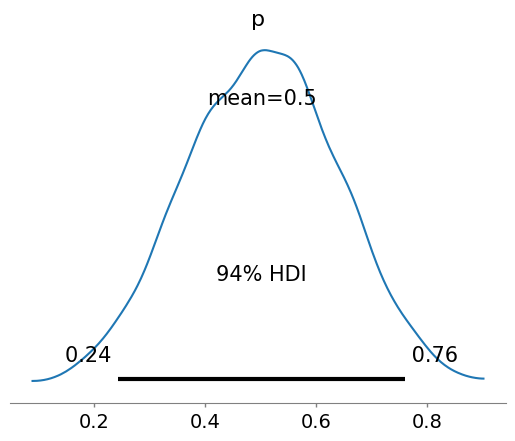

In [5]:
import arviz as az

az.plot_posterior(idata, show=True);